# Weighted Max Cut Social Networks
### James Saslow
### 12/11/2023

The weighted max cut is similar to the regular max cut, except weighted max cut has weights assigned to each edge (connection). 
This means the amount of cuts and the value of each cut must be considered to determine what the max cut is for some node network.


Because max cuts are useful for partitioning items into catagories based on the relationship (connection) each item has wth each other, we can use weighted max cuts to split up social networks into two groups of people who are mostly friends.

For instance, let's say I'm throwing a dinner party and I want to invite a ton of friends! I have two tables (Conveniently names table '0' and table '1'). 

I want to organize my party such that people that are on good terms with one another sit at the same table, and people that aren't on good terms with one another are sitting at different tables (ideally). I want to do this because I want to minimize the amount of potential arguing and fighting that could occur at the party if there is too much conflict at one table. 

Recall, from the previous tutorial, we learned that 

1) If $i,j$ share a connection and $i$ and $j$ are part of the same class, then $C_{i,j} = 0$, which implies **do not make a cut**

2) If $i,j$ share a connection and $i$ and $j$ are part of different classes, then $C_{i,j} = - w_{i,j}$ which implies to **make a cut**

So, we need a way to rank friendships using the weight between each node $w_{i,j}$

Here is the friendship scale:

In [9]:
# Importing Packages

import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel

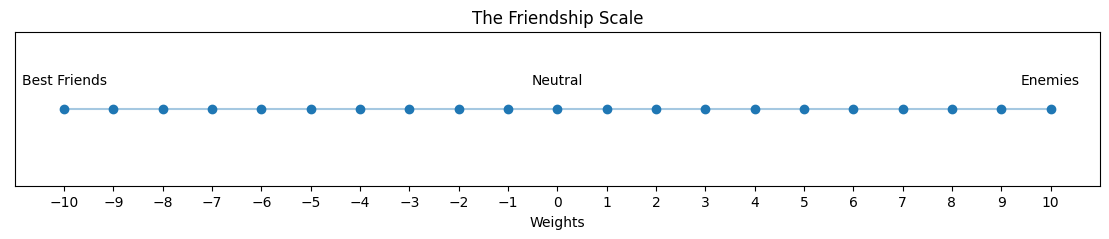

In [2]:
# Plotting a 'Friendship Scale' that we can use to map relationships -> weights

plt.figure(figsize = (14,2))
x = np.arange(-10,11)
y = np.zeros((21))
N = len(x)

plt.title('The Friendship Scale')
plt.scatter(x,y)
plt.plot([x[0],x[-1]],[y[0],y[-1]], alpha = 0.4)
plt.xlabel('Weights')
plt.xticks(x)
plt.yticks([])
    
    
plt.text(x[0], y[0] + 0.015, 'Best Friends', ha = 'center', va = 'bottom')
plt.text(x[-1], y[-1] + 0.015, 'Enemies', ha = 'center', va = 'bottom')
plt.text(x[N//2], y[N//2] + 0.015, 'Neutral', ha = 'center', va = 'bottom')
    
plt.show()

So why is friendliness a positive weight and unfriendliness a negative weight? 

Well, if we want to make a cut between two members $i$ and $j$ that do not get along, then we need to make a cut to seperate the two. Making a cut means we have to append the following to our total cost: $C_{i,j} = - w_{i,j}$. If $w_{i,j}$ is positive, then $C_{i,j}$  is negative, and we want to make $\sum_{(i,j)}C_{i,j}$ as negative as possible to find the global minimum where the 2 table groups are optimized for friendliness.

And why is $0$ neutral? Well, a zero weight means that there is no connection at all between two nodes. Perhaps this can symbolize 2 people that have yet to meet or 2 people that don't like each other but don't necessarily dislike each other either.

### Writing the Social Network as a Node Network

Here is the guest list of my friends I want to invite to my party (I'm using the characters from Spongebob as an example since this friendship dynamic may be familiar to those who have seen the show)

My guest list:

- Spongebob
- Squidward
- Plankton
- Mr Krabs
- Karen
- Squiliam

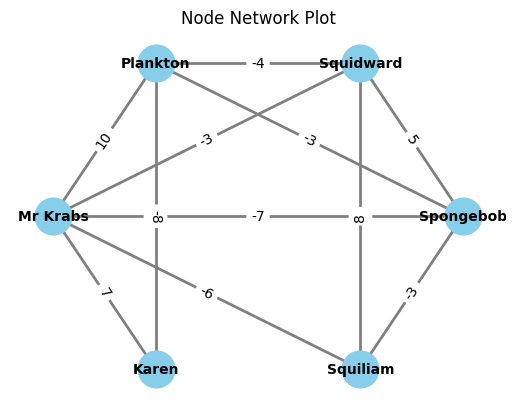

In [10]:
# Using a node network to define relationships

G = nx.Graph() # Prompting Empty Node Network

# Encoding Relationships as edgess
G.add_edge("Spongebob", "Squidward", weight = 5) # Sometimes Spongebob annoys squidward
G.add_edge("Spongebob","Plankton", weight = -3) # They are on okay terms
G.add_edge("Spongebob", "Mr Krabs", weight = -7) # Good Boss - Employee Relationship
G.add_edge("Plankton", "Mr Krabs", weight = 10) # Enemies
G.add_edge("Plankton", "Squidward", weight = -4) # Would probably get along
G.add_edge("Mr Krabs", "Squidward", weight = -3) # Okay boss - employee relationship
G.add_edge("Karen", "Plankton", weight = -8) # Husband & Wife
G.add_edge("Karen", "Mr Krabs", weight = 7) # Karen is on Plankton's side
G.add_edge("Squiliam", "Squidward", weight = 8) # Rivals
G.add_edge("Spongebob", "Squiliam", weight = -3) # Acquaintances
G.add_edge("Squiliam", "Mr Krabs", weight = -6) # Mr Krabs thinks highly of Squiliam


# Plotting the node network
pos = nx.circular_layout(G)
plt.title('Node Network Plot')
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue",
        font_size=10, font_color="black", font_weight="bold", width=2, edge_color="gray")
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

### Solving the $C'(X) = \sum_{(i,j)} w_{i,j} (-x_{i} -x_{j} + 2 x_{i}x_{j})$ cost function associated with the weighted max cut problem on DWave

In [11]:
bqm = BinaryQuadraticModel('BINARY') # Empty QUBO Template

for edge in G.edges:
    i,j = edge # Getting the nodes that share an edge and storing them in i,j
    bqm.add_variable(i,-1)
    bqm.add_variable(j,-1)
    weight = G[i][j]['weight']
    bqm.add_interaction(i,j,2*weight)
    
bqm

BinaryQuadraticModel({'Spongebob': -4.0, 'Squidward': -4.0, 'Plankton': -4.0, 'Mr Krabs': -5.0, 'Squiliam': -3.0, 'Karen': -2.0}, {('Squidward', 'Spongebob'): 10.0, ('Plankton', 'Spongebob'): -6.0, ('Plankton', 'Squidward'): -8.0, ('Mr Krabs', 'Spongebob'): -14.0, ('Mr Krabs', 'Squidward'): -6.0, ('Mr Krabs', 'Plankton'): 20.0, ('Squiliam', 'Spongebob'): -6.0, ('Squiliam', 'Squidward'): 16.0, ('Squiliam', 'Mr Krabs'): -12.0, ('Karen', 'Plankton'): -16.0, ('Karen', 'Mr Krabs'): 14.0}, 0.0, 'BINARY')

In [12]:
# Solve the problem using D-Wave
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=10)

In [13]:
# Post-Processing Solver Output
opt_solution = sampleset.first.sample # Binary Bit-String that minimizes the cost function
opt_value = sampleset.first.energy    

In [14]:
print('X_min = ', opt_solution)
print('C_min = ', opt_value)

X_min =  {'Karen': 0, 'Mr Krabs': 1, 'Plankton': 0, 'Spongebob': 1, 'Squidward': 0, 'Squiliam': 1}
C_min =  -44.0


Blue = Class '0'
Red = Class '1'


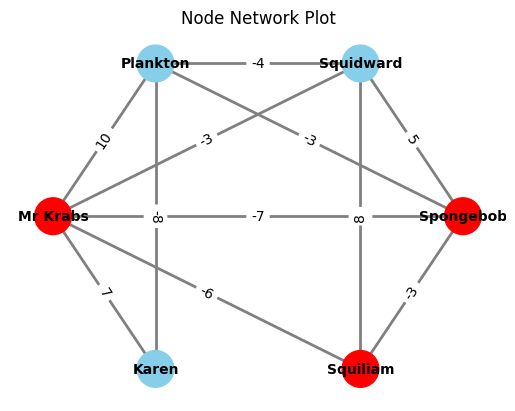

In [15]:
# Coloring the '0' class with blue and the '1' class with red

colors = []
for i in G.nodes:
    loc = list(opt_solution.keys()).index(i)
    binary_variable = (list(opt_solution.values()))[loc]
    if binary_variable == 0:
        colors.append("skyblue")
    else:
        colors.append("red")

print("Blue = Class '0'")
print("Red = Class '1'")
        
        
# Plotting the node network solution
plt.title('Node Network Plot')
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color=colors,
        font_size=10, font_color="black", font_weight="bold", width=2, edge_color="gray")
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

### According to DWave, it is advantageous to group {Plankton, Squidward, Karen} together at one table and to group {Spongebob, Mr Krabs, Squiliam} together at another table

### Sources


[1] Dwave-Examples, “Dwave-examples/maximum-cut: Solve a max-cut problem using a quantum computer,” GitHub, https://github.com/dwave-examples/maximum-cut (accessed Dec. 11, 2023). 

[2] “Max-cut and traveling salesman problem#,” Max-Cut and Traveling Salesman Problem - Qiskit Optimization 0.6.0, https://qiskit.org/ecosystem/optimization/tutorials/06_examples_max_cut_and_tsp.html (accessed Dec. 11, 2023). 

[3] “21.Classical optimization: Maxcut problem,” YouTube, https://www.youtube.com/watch?v=LMmQ5LD308A (accessed Dec. 11, 2023). 

[4] “Binary quadratic models#,” Binary Quadratic Models - Ocean Documentation 6.7.1 documentation, https://docs.ocean.dwavesys.com/en/stable/concepts/bqm.html (accessed Dec. 11, 2023). 

[5] “Quantum programming tutorial | D-wave qubits 2021,” YouTube, https://www.youtube.com/watch?v=jTDnGox0c9Y (accessed Dec. 11, 2023). 